<a href="https://colab.research.google.com/github/saimasharleen/Active-Learning-Strategies-Across-Diverse-Machine-Learning-Models/blob/main/MNIST_KNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install git+https://github.com/modAL-python/modAL.git

  Cloning https://github.com/modAL-python/modAL.git to /tmp/pip-req-build-t3bxauvd
  Running command git clone --filter=blob:none --quiet https://github.com/modAL-python/modAL.git /tmp/pip-req-build-t3bxauvd
  Resolved https://github.com/modAL-python/modAL.git to commit bba6f6fd00dbb862b1e09259b78caf6cffa2e755
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.8/125.8 kB 3.2 MB/s eta 0:00:00
  Created wheel for modAL-python: filename=modAL_python-0.4.2-py3-none-any.whl size=32650 sha256=bdb13c447c1adee8d89fdbe6e4e203c8a42f0aab1979cc95a7d417844be10212
  Stored in directory: /tmp/pip-ephem-wheel-cache-fksj_b3m/wheels/d9/fb/59/7deb61b460c1c36394cd093758986ff7d36f71352dcb2e02c5
Successfully built modAL-python


In [2]:
import numpy as np
import joblib
from sklearn.neighbors import KNeighborsClassifier
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torchvision.datasets import MNIST
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from modAL.models import ActiveLearner
from modAL.uncertainty import uncertainty_sampling

In [3]:
# Load MNIST data
mnist_data = MNIST('.', download=True, transform=ToTensor())
dataloader = DataLoader(mnist_data, shuffle=True, batch_size=60000)
x, y = next(iter(dataloader))

100%|██████████| 9912422/9912422 [00:00<00:00, 309485858.39it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 32765943.69it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 161767669.27it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw




100%|██████████| 4542/4542 [00:00<00:00, 3328766.17it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [4]:
# Preprocessing
x = x.detach().cpu().numpy().reshape(x.size(0), -1)  # Flatten the images
y = y.detach().cpu().numpy()

In [5]:
# Split data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=10000, random_state=0, stratify=y)

In [6]:
# Define confusion matrix print function
def CF_Print(y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    CF = confusion_matrix(y_test, y_pred)
    macro_f1 = f1_score(y_test, y_pred, average='macro')
    micro_f1 = f1_score(y_test, y_pred, average='micro')
    weighted_f1 = f1_score(y_test, y_pred, average='weighted')
    print('Confusion Matrix:')
    print(CF)
    print('Accuracy: ', accuracy)
    print('Macro F1-score: ', macro_f1)
    print('Micro F1-score: ', micro_f1)
    print('Weighted F1-score: ', weighted_f1)
    print("---------------------------------")

In [7]:
# Active Learning with KNN
def AL_Retrain(n_initial, n_queries, instances):
    x_initial, x_pool, y_initial, y_pool = train_test_split(x_train, y_train, train_size=n_initial, random_state=0, stratify=y_train)

    # Initialize the learner
    learner = ActiveLearner(
        estimator=KNeighborsClassifier(n_neighbors=3),
        query_strategy=uncertainty_sampling,
        X_training=x_initial, y_training=y_initial
    )

    print("Number of initial data: ", n_initial)
    y_pred = learner.predict(x_test)
    CF_Print(y_test, y_pred)

    # Active Learning Loop
    for idx in range(n_queries):
        print('--- Query no: ', idx+1, ' ----')
        query_idx, query_instance = learner.query(x_pool, n_instances=instances)
        learner.teach(X=x_pool[query_idx], y=y_pool[query_idx])
        print('Instance', y_pool[query_idx])
        y_pred = learner.predict(x_test)
        CF_Print(y_test, y_pred)

        # Update the pool
        x_pool = np.delete(x_pool, query_idx, axis=0)
        y_pool = np.delete(y_pool, query_idx, axis=0)

In [8]:
AL_Retrain(30, 10, 20)

Number of initial data:  30
Confusion Matrix:
[[ 788   23   86   12    4   37   32    3    1    1]
 [   0 1105    0    0    1    0    0   17    0    1]
 [ 144  351  358   10   11   10    7   89   10    3]
 [  58  226  161  492    7   21    4   28   13   12]
 [  25  157   71    2  567    1   11   20    9  111]
 [ 185  231   46  187   71  101    7    5   20   50]
 [ 288  234   19    6    6   10  411    0    6    6]
 [  39  153    8   16  304    4    7  428    0   85]
 [ 117  433  122   33   15   20    2   27  190   16]
 [  18  146   39   26  368    1    5  121    5  263]]
Accuracy:  0.4703
Macro F1-score:  0.44033288056838416
Micro F1-score:  0.4703
Weighted F1-score:  0.44429668054702687
---------------------------------
--- Query no:  1  ----
Instance [2 8 4 4 8 2 1 7 6 9 9 2 4 6 0 8 4 6 2 2]
Confusion Matrix:
[[ 813    5   38    5   15   22   30    0   58    1]
 [   0 1104    5    1    3    0    0    1    0   10]
 [  61  164  659    6   29    2   24   44    2    2]
 [  53  171  273  4

In [9]:
AL_Retrain(30, 10, 30)

Number of initial data:  30
Confusion Matrix:
[[ 788   23   86   12    4   37   32    3    1    1]
 [   0 1105    0    0    1    0    0   17    0    1]
 [ 144  351  358   10   11   10    7   89   10    3]
 [  58  226  161  492    7   21    4   28   13   12]
 [  25  157   71    2  567    1   11   20    9  111]
 [ 185  231   46  187   71  101    7    5   20   50]
 [ 288  234   19    6    6   10  411    0    6    6]
 [  39  153    8   16  304    4    7  428    0   85]
 [ 117  433  122   33   15   20    2   27  190   16]
 [  18  146   39   26  368    1    5  121    5  263]]
Accuracy:  0.4703
Macro F1-score:  0.44033288056838416
Micro F1-score:  0.4703
Weighted F1-score:  0.44429668054702687
---------------------------------
--- Query no:  1  ----
Instance [6 9 8 6 0 2 4 2 6 3 8 4 6 8 2 4 2 9 9 6 7 1 2 8 4 4 3 6 9 2]
Confusion Matrix:
[[ 787    5   51   11   16   18   50    0   47    2]
 [   0 1104    5    1    3    0    0    1    0   10]
 [  53  167  654    8   27    1   34   42    4    3]

In [10]:
AL_Retrain(50, 10, 20)

Number of initial data:  50
Confusion Matrix:
[[ 899    9    4   11    0    6   49    5    0    4]
 [   0 1082    0    0    2    0    0   40    0    0]
 [ 140  430  313    7   19    5   16   53    3    7]
 [  50  216  139  510    6   12    9   26    5   49]
 [  14  109   32    0  519    0   18   33    5  244]
 [ 150  187   21  176   58   84   30   62   16  119]
 [ 201  191   10    2   12    3  562    0    4    1]
 [  12  100    3    3   99    8   25  637    0  157]
 [  75  347  149   33   23   12    6   61  207   62]
 [  14   51   29   10  230    2    0  128    3  525]]
Accuracy:  0.5338
Macro F1-score:  0.5008190115074074
Micro F1-score:  0.5338
Weighted F1-score:  0.5054380715325325
---------------------------------
--- Query no:  1  ----
Instance [5 1 2 2 3 4 8 2 2 6 8 8 2 0 3 2 7 8 5 0]
Confusion Matrix:
[[ 894    9    5   16    3   10   41    1    5    3]
 [   0 1119    0    1    2    0    0    1    1    0]
 [  51  291  568    4   19    2   12   27   15    4]
 [  84  174   94  582

In [11]:
AL_Retrain(50, 10, 30)

Number of initial data:  50
Confusion Matrix:
[[ 899    9    4   11    0    6   49    5    0    4]
 [   0 1082    0    0    2    0    0   40    0    0]
 [ 140  430  313    7   19    5   16   53    3    7]
 [  50  216  139  510    6   12    9   26    5   49]
 [  14  109   32    0  519    0   18   33    5  244]
 [ 150  187   21  176   58   84   30   62   16  119]
 [ 201  191   10    2   12    3  562    0    4    1]
 [  12  100    3    3   99    8   25  637    0  157]
 [  75  347  149   33   23   12    6   61  207   62]
 [  14   51   29   10  230    2    0  128    3  525]]
Accuracy:  0.5338
Macro F1-score:  0.5008190115074074
Micro F1-score:  0.5338
Weighted F1-score:  0.5054380715325325
---------------------------------
--- Query no:  1  ----
Instance [3 3 7 5 2 8 8 8 0 0 2 4 3 6 1 5 0 2 8 8 6 2 2 8 4 3 2 2 8 5]
Confusion Matrix:
[[ 894    6    4   13    2   22   38    1    4    3]
 [   0 1113    0    1    2    0    0    1    7    0]
 [  56  285  570    8   16    5   12   23   14    4]
 

In [12]:
 AL_Retrain(100, 10, 20)

Number of initial data:  100
Confusion Matrix:
[[ 891    7    1   18    1   24   35    3    3    4]
 [   0 1113    0    0    3    0    0    6    0    2]
 [  49  287  501   52   12    7   29   43    4    9]
 [  11   94   17  769   11   41    9   17   18   35]
 [   6   88   21    0  603    3   25   14    0  214]
 [  65  117    5  144   35  389   22    9   22   95]
 [  59   98    9    5   15   12  787    0    0    1]
 [   8  103    1    1   84    8   17  698    0  124]
 [  41  305  105  156   35   68   11   16  174   64]
 [  12   47   21   13  217    7    1   52    3  619]]
Accuracy:  0.6544
Macro F1-score:  0.6353815672061066
Micro F1-score:  0.6544
Weighted F1-score:  0.6377467946623155
---------------------------------
--- Query no:  1  ----
Instance [5 5 9 8 6 5 2 6 8 4 3 2 3 0 0 2 2 9 4 5]
Confusion Matrix:
[[ 911    4    2    9    1   28   24    1    3    4]
 [   0 1111    1    0    3    0    0    5    1    3]
 [  88  176  629   31    8    3   19   25    2   12]
 [  12   86   33  76

In [13]:
AL_Retrain(300, 10, 20)

Number of initial data:  300
Confusion Matrix:
[[ 916    3    7   11    1    9   29    6    2    3]
 [   0 1116    1    0    2    1    0    2    0    2]
 [  45  184  653   20   14    2    9   48   13    5]
 [  10   94   25  793    6   28    3   13   20   30]
 [   6   51   12    0  683    6   19   12    2  183]
 [  34   95    4  100   16  572   16   14   15   37]
 [  40   71    8    0   22   24  820    0    0    1]
 [   3   85    5    1   26    0    1  824    0   99]
 [  25  128   22   75   13   35    7   16  595   59]
 [  11   19    4   13  147    4    0   29    2  763]]
Accuracy:  0.7735
Macro F1-score:  0.7728881333352129
Micro F1-score:  0.7735
Weighted F1-score:  0.7733796484648339
---------------------------------
--- Query no:  1  ----
Instance [3 3 6 2 8 8 5 5 8 2 7 2 5 6 3 5 8 8 5 2]
Confusion Matrix:
[[ 910    3    8   11    1   15   29    6    1    3]
 [   0 1116    1    0    2    1    0    2    0    2]
 [  37  147  710   18   11    7    9   39   11    4]
 [   9   87   28  77

In [14]:

AL_Retrain(300, 10, 30)

Number of initial data:  300
Confusion Matrix:
[[ 916    3    7   11    1    9   29    6    2    3]
 [   0 1116    1    0    2    1    0    2    0    2]
 [  45  184  653   20   14    2    9   48   13    5]
 [  10   94   25  793    6   28    3   13   20   30]
 [   6   51   12    0  683    6   19   12    2  183]
 [  34   95    4  100   16  572   16   14   15   37]
 [  40   71    8    0   22   24  820    0    0    1]
 [   3   85    5    1   26    0    1  824    0   99]
 [  25  128   22   75   13   35    7   16  595   59]
 [  11   19    4   13  147    4    0   29    2  763]]
Accuracy:  0.7735
Macro F1-score:  0.7728881333352129
Micro F1-score:  0.7735
Weighted F1-score:  0.7733796484648339
---------------------------------
--- Query no:  1  ----
Instance [3 3 6 2 8 8 5 5 8 2 7 2 5 6 3 5 8 8 5 2 3 8 8 4 3 4 5 1 4 2]
Confusion Matrix:
[[ 910    3    9   11    1   15   29    5    1    3]
 [   0 1117    1    0    2    1    0    2    0    1]
 [  36  145  719   18   10    5    8   38   12    2]


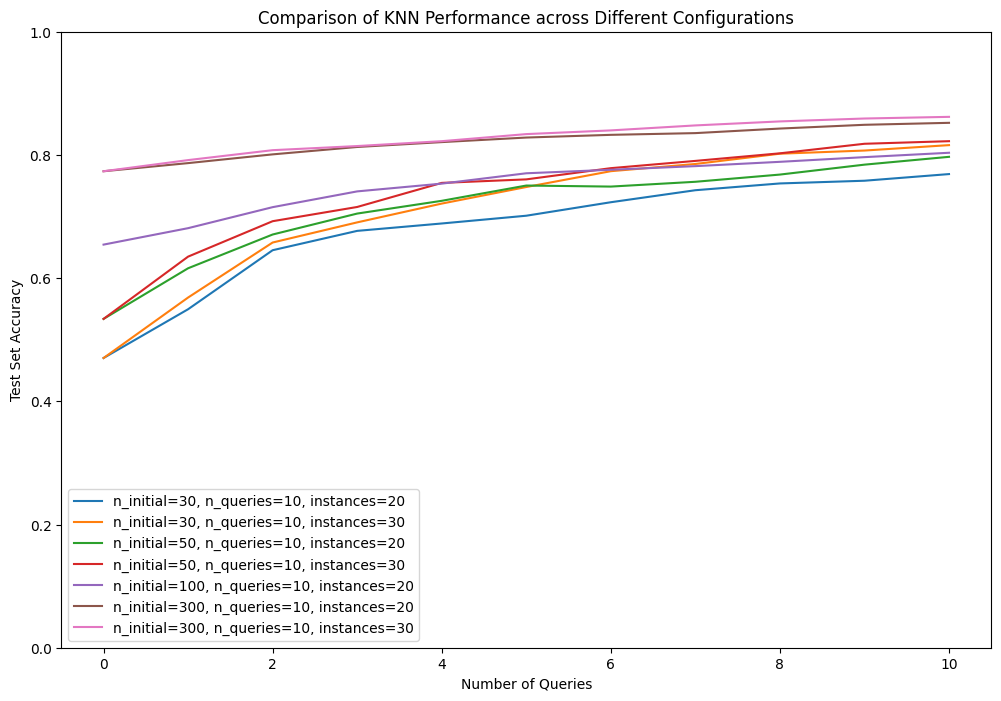

In [15]:
#plot_for_perfromance_change_queries
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from modAL.models import ActiveLearner
from modAL.uncertainty import uncertainty_sampling
from sklearn.neighbors import KNeighborsClassifier

# Define the active learning function with parameters for KNN
def AL_Retrain(n_initial, n_queries, instances, x_train, y_train, x_test, y_test):
    x_initial, x_pool, y_initial, y_pool = train_test_split(x_train, y_train, train_size=n_initial, random_state=0, stratify=y_train)

    learner = ActiveLearner(
        estimator=KNeighborsClassifier(n_neighbors=3),
        query_strategy=uncertainty_sampling,
        X_training=x_initial, y_training=y_initial
    )

    performance_history = [accuracy_score(y_test, learner.predict(x_test))]

    # Active Learning Loop
    for idx in range(n_queries):
        query_idx, query_instance = learner.query(x_pool, n_instances=instances)
        learner.teach(X=x_pool[query_idx], y=y_pool[query_idx])

        # Remove the queried instance from the pool
        x_pool = np.delete(x_pool, query_idx, axis=0)
        y_pool = np.delete(y_pool, query_idx, axis=0)

        # Calculate and record performance
        model_accuracy = accuracy_score(y_test, learner.predict(x_test))
        performance_history.append(model_accuracy)

    return performance_history

# Configurations to compare
configurations = [
    (30, 10, 20),
    (30, 10, 30),
    (50, 10, 20),
    (50, 10, 30),
    (100, 10, 20),
    (300, 10, 20),
    (300, 10, 30)
]

# Run each configuration
performance_histories = {}
for config in configurations:
    n_initial, n_queries, instances = config
    performance_histories[config] = AL_Retrain(n_initial, n_queries, instances, x_train, y_train, x_test, y_test)

# Plot the performances
plt.figure(figsize=(12, 8))
for config, history in performance_histories.items():
    plt.plot(history, label=f'n_initial={config[0]}, n_queries={config[1]}, instances={config[2]}')

plt.title("Comparison of KNN Performance across Different Configurations")
plt.xlabel("Number of Queries")
plt.ylabel("Test Set Accuracy")
plt.legend()
plt.ylim(0, 1)
plt.show()
